In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline

In [2]:
data = pd.read_csv("input/creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
data['Hour'] = data["Time"].apply(lambda x : divmod(x, 3600)[0])

In [4]:
droplist = [ 'V13', 'V15', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28','Time']
#droplist = [ 'V13', 'V15',  'V22', 'V24', 'V25']
data_new = data.drop(droplist, axis = 1)

In [5]:
from sklearn.preprocessing import StandardScaler




col = ['Amount','Hour']
sc =StandardScaler() 
data_new[col] =sc.fit_transform(data_new[col])

data = data_new

In [6]:
from imblearn.over_sampling import SMOTE
import itertools
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,f1_score, precision_score

from sklearn.grid_search import GridSearchCV
from sklearn import cross_validation, metrics
from sklearn.metrics import average_precision_score
from sklearn.cross_validation import train_test_split

 # Whole dataset
X = data.ix[:, data.columns != 'Class']
y = data.ix[:, data.columns == 'Class']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)

sm = SMOTE(random_state=0)
columns = X_train.columns
X_oversample,y_oversample=sm.fit_sample(X_train,y_train)

/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A

In [7]:
X_oversample = pd.DataFrame(data=X_oversample,columns=columns )
y_oversample= pd.DataFrame(data=y_oversample,columns=["Class"])

In [8]:
print('X_oversample length: ', len(X_oversample))
print('Proportion of fraud data in oversampled data is ', len(y_oversample[y_oversample['Class']==1]))
print('Proportion of normal data in oversampled data is ', len(y_oversample[y_oversample['Class']==0]))

X_oversample length:  398038
Proportion of fraud data in oversampled data is  199019
Proportion of normal data in oversampled data is  199019


In [9]:
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_oversample,y_oversample,test_size = 0.3,random_state = 0)

In [10]:
c, r = y_train_smote.shape
y_train_smote = y_train_smote.values.reshape(c,)

In [11]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier  #xgboost algorithm
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

target='Class'

In [12]:
def modelfit(alg, X, y,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X.values, label=y)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X, y,eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(X)
    dtrain_predprob = alg.predict_proba(X)[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Recall : %.4g" % metrics.recall_score(y, dtrain_predictions))
    print("Precision : %.4g" % metrics.precision_score(y, dtrain_predictions))
    print ("Average_precision : %.4g" % metrics.average_precision_score(y, dtrain_predictions))
    #print "AUC Score (Train): %f" % metrics.roc_auc_score(y, dtrain_predprob)
                    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Model Report
Recall : 0.8299
Precision : 0.9606
Average_precision : 0.7976


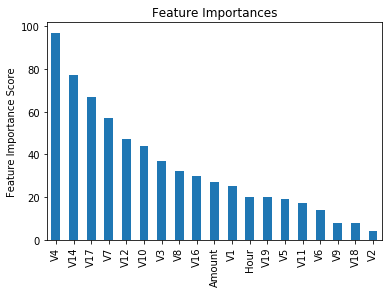

In [64]:
xgb1 = XGBClassifier()
modelfit(xgb1, X_test, y_test)

In [29]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
X=X_train_smote
y=y_train_smote
alg=xgb1
cv_folds=5
early_stopping_rounds=50

xgb_param = alg.get_xgb_params()
xgtrain = xgb.DMatrix(X.values, label=y)
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
alg.set_params(n_estimators=cvresult.shape[0])
 #Fit the algorithm on the data
alg.fit(X, y,eval_metric='auc')
        
    #Predict training set:
dtrain_predictions = alg.predict(X)
dtrain_predprob = alg.predict_proba(X)[:,1]

In [32]:
print("\nModel Report")
print("Recall : %.4g" % metrics.recall_score(y, dtrain_predictions))
print("Precision : %.4g" % metrics.precision_score(y, dtrain_predictions))
print ("Average_precision : %.4g" % metrics.average_precision_score(y, dtrain_predictions))


Model Report
Recall : 1
Precision : 1
Average_precision : 1


Text(0,0.5,'Feature Importance Score')

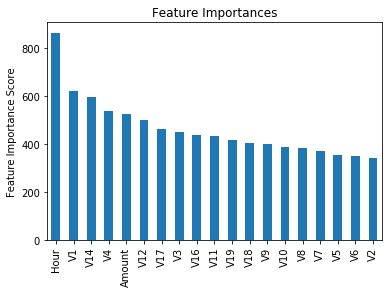

In [48]:
feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [49]:
X_whole_prediction = alg.predict(X_test)

In [50]:
print("\nModel Report")
print("Recall : %.4g" % metrics.recall_score(y_test, X_whole_prediction))
print("Precision : %.4g" % metrics.precision_score(y_test, X_whole_prediction))
print ("Average_precision : %.4g" % metrics.average_precision_score(y_test, X_whole_prediction))


Model Report
Recall : 0.8299
Precision : 0.7219
Average_precision : 0.5994


### Tune parameter

In [13]:
'''param_test1 = {
 'max_depth':[7, 9, 10, 11],
 'min_child_weight':list(range(1,6,2))
}'''
param_test1 = {
 'n_estimators':[80, 100, 120, 140, 160],
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='average_precision',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train_smote,y_train_smote)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_


([mean: 0.99979, std: 0.00006, params: {'n_estimators': 80},
  mean: 0.99987, std: 0.00005, params: {'n_estimators': 100},
  mean: 0.99990, std: 0.00004, params: {'n_estimators': 120},
  mean: 0.99993, std: 0.00004, params: {'n_estimators': 140},
  mean: 0.99995, std: 0.00004, params: {'n_estimators': 160}],
 {'n_estimators': 160},
 0.9999458225310767)

In [12]:
param_test2 = {
 'max_depth':[7, 9, 10, 11],
 'min_child_weight':list(range(1,6,2))
}

gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=160, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test2, scoring='average_precision',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_train_smote,y_train_smote)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_



([mean: 0.99998, std: 0.00002, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.99997, std: 0.00002, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.99996, std: 0.00003, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.99998, std: 0.00002, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.99998, std: 0.00002, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.99998, std: 0.00002, params: {'max_depth': 9, 'min_child_weight': 5},
  mean: 0.99998, std: 0.00002, params: {'max_depth': 10, 'min_child_weight': 1},
  mean: 0.99998, std: 0.00002, params: {'max_depth': 10, 'min_child_weight': 3},
  mean: 0.99997, std: 0.00002, params: {'max_depth': 10, 'min_child_weight': 5},
  mean: 0.99999, std: 0.00001, params: {'max_depth': 11, 'min_child_weight': 1},
  mean: 0.99998, std: 0.00002, params: {'max_depth': 11, 'min_child_weight': 3},
  mean: 0.99997, std: 0.00002, params: {'max_depth': 11, 'min_child_weight': 5}],
 {'max_depth': 11, 'min_child_wei

In [12]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=160, max_depth=11,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test3, scoring='average_precision',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_train_smote,y_train_smote)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_



([mean: 0.99999, std: 0.00001, params: {'gamma': 0.0},
  mean: 0.99999, std: 0.00001, params: {'gamma': 0.1},
  mean: 0.99998, std: 0.00002, params: {'gamma': 0.2},
  mean: 0.99999, std: 0.00001, params: {'gamma': 0.3},
  mean: 0.99999, std: 0.00001, params: {'gamma': 0.4}],
 {'gamma': 0.1},
 0.9999896318678276)

In [13]:
xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=160,
 max_depth=11,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
X=X_train_smote
y=y_train_smote
alg=xgb3
cv_folds=5
early_stopping_rounds=50

xgb_param = alg.get_xgb_params()
xgtrain = xgb.DMatrix(X.values, label=y)
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
alg.set_params(n_estimators=cvresult.shape[0])
 #Fit the algorithm on the data
alg.fit(X, y,eval_metric='auc')
        
    #Predict training set:
dtrain_predictions = alg.predict(X)
dtrain_predprob = alg.predict_proba(X)[:,1]

In [14]:
X_whole_prediction = alg.predict(X_test)
print("\nModel Report")
print("Recall : %.4g" % metrics.recall_score(y_test, X_whole_prediction))
print("Precision : %.4g" % metrics.precision_score(y_test, X_whole_prediction))
print ("Average_precision : %.4g" % metrics.average_precision_score(y_test, X_whole_prediction))


Model Report
Recall : 0.8367
Precision : 0.764
Average_precision : 0.6395


In [23]:
xgb4 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=400,
 max_depth=14,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
X=X_train_smote
y=y_train_smote
alg=xgb4
cv_folds=5
early_stopping_rounds=50

xgb_param = alg.get_xgb_params()
xgtrain = xgb.DMatrix(X.values, label=y)
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
alg.set_params(n_estimators=cvresult.shape[0])
 #Fit the algorithm on the data
alg.fit(X, y,eval_metric='auc')
        
    #Predict training set:
dtrain_predictions = alg.predict(X)
dtrain_predprob = alg.predict_proba(X)[:,1]

In [20]:
X_whole_prediction = alg.predict(X_test)
print("\nModel Report")
print("Recall : %.4g" % metrics.recall_score(y_test, X_whole_prediction))
print("Precision : %.4g" % metrics.precision_score(y_test, X_whole_prediction))
print ("Average_precision : %.4g" % metrics.average_precision_score(y_test, X_whole_prediction))


Model Report
Recall : 0.8367
Precision : 0.7885
Average_precision : 0.66


In [24]:
X_whole_prediction = alg.predict(X_test)
print("\nModel Report")
print("Recall : %.4g" % metrics.recall_score(y_test, X_whole_prediction))
print("Precision : %.4g" % metrics.precision_score(y_test, X_whole_prediction))
print ("Average_precision : %.4g" % metrics.average_precision_score(y_test, X_whole_prediction))


Model Report
Recall : 0.8367
Precision : 0.7885
Average_precision : 0.66


In [25]:
xgb5 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=300,
 max_depth=12,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
X=X_train_smote
y=y_train_smote
alg=xgb5
cv_folds=5
early_stopping_rounds=50

xgb_param = alg.get_xgb_params()
xgtrain = xgb.DMatrix(X.values, label=y)
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
alg.set_params(n_estimators=cvresult.shape[0])
 #Fit the algorithm on the data
alg.fit(X, y,eval_metric='auc')
        
    #Predict training set:
dtrain_predictions = alg.predict(X)
dtrain_predprob = alg.predict_proba(X)[:,1]

In [26]:
X_whole_prediction = alg.predict(X_test)
print("\nModel Report")
print("Recall : %.4g" % metrics.recall_score(y_test, X_whole_prediction))
print("Precision : %.4g" % metrics.precision_score(y_test, X_whole_prediction))
print ("Average_precision : %.4g" % metrics.average_precision_score(y_test, X_whole_prediction))


Model Report
Recall : 0.8367
Precision : 0.7834
Average_precision : 0.6558


In [12]:
param_test6 = {
 'subsample':[0.6, 0.7, 0.8],
 'colsample_bytree':[0.6, 0.7, 0.8]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=360, max_depth=14,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test6, scoring='average_precision',n_jobs=4,iid=False, cv=5)
gsearch6.fit(X_train_smote,y_train_smote)
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_


([mean: 0.99998, std: 0.00002, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: 0.99999, std: 0.00001, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: 0.99999, std: 0.00001, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: 0.99998, std: 0.00002, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: 0.99999, std: 0.00001, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: 0.99998, std: 0.00001, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: 0.99999, std: 0.00001, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: 0.99999, std: 0.00001, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
  mean: 0.99999, std: 0.00001, params: {'colsample_bytree': 0.8, 'subsample': 0.8}],
 {'colsample_bytree': 0.6, 'subsample': 0.7},
 0.9999874741268193)

In [13]:
xgb6 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=360,
 max_depth=14,
 min_child_weight=1,
 gamma=0,
 subsample=0.7,
 colsample_bytree=0.6,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
X=X_train_smote
y=y_train_smote
alg=xgb6
cv_folds=5
early_stopping_rounds=50

xgb_param = alg.get_xgb_params()
xgtrain = xgb.DMatrix(X.values, label=y)
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
alg.set_params(n_estimators=cvresult.shape[0])
 #Fit the algorithm on the data
alg.fit(X, y,eval_metric='auc')
        
    #Predict training set:
dtrain_predictions = alg.predict(X)
dtrain_predprob = alg.predict_proba(X)[:,1]

In [14]:
X_whole_prediction = alg.predict(X_test)
print("\nModel Report")
print("Recall : %.4g" % metrics.recall_score(y_test, X_whole_prediction))
print("Precision : %.4g" % metrics.precision_score(y_test, X_whole_prediction))
print ("Average_precision : %.4g" % metrics.average_precision_score(y_test, X_whole_prediction))


Model Report
Recall : 0.8367
Precision : 0.8092
Average_precision : 0.6774


In [13]:
param_test7 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=360, max_depth=14,
 min_child_weight=1, gamma=0, subsample=0.7, colsample_bytree=0.6,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test7, scoring='average_precision',n_jobs=4,iid=False, cv=5)
gsearch7.fit(X_train_smote,y_train_smote)
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_



([mean: 0.99999, std: 0.00001, params: {'reg_alpha': 1e-05},
  mean: 0.99999, std: 0.00002, params: {'reg_alpha': 0.01},
  mean: 0.99999, std: 0.00001, params: {'reg_alpha': 0.1},
  mean: 0.99999, std: 0.00002, params: {'reg_alpha': 1},
  mean: 0.99986, std: 0.00005, params: {'reg_alpha': 100}],
 {'reg_alpha': 0.1},
 0.9999877601409801)

In [13]:
param_test7 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=360, max_depth=14,
 min_child_weight=1, gamma=0, subsample=0.7, colsample_bytree=0.6,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test7, scoring='average_precision',n_jobs=4,iid=False, cv=5)
gsearch7.fit(X_train_smote,y_train_smote)
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

([mean: 0.99999, std: 0.00001, params: {'reg_alpha': 0},
  mean: 0.99999, std: 0.00001, params: {'reg_alpha': 0.001},
  mean: 0.99999, std: 0.00001, params: {'reg_alpha': 0.005},
  mean: 0.99999, std: 0.00002, params: {'reg_alpha': 0.01},
  mean: 0.99999, std: 0.00001, params: {'reg_alpha': 0.05}],
 {'reg_alpha': 0.05},
 0.9999878066282637)

In [15]:

xgb7 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=360,
 max_depth=14,
 min_child_weight=1,
 gamma=0,
 subsample=0.7,
 colsample_bytree=0.6,
 objective= 'binary:logistic',
 reg_alpha=0.005,
 nthread=4,
 scale_pos_weight=1,
 seed=27)
X=X_train_smote
y=y_train_smote
alg=xgb7
cv_folds=5
early_stopping_rounds=50

xgb_param = alg.get_xgb_params()
xgtrain = xgb.DMatrix(X.values, label=y)
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
alg.set_params(n_estimators=cvresult.shape[0])
 #Fit the algorithm on the data
alg.fit(X, y,eval_metric='auc')
        
    #Predict training set:
dtrain_predictions = alg.predict(X)
dtrain_predprob = alg.predict_proba(X)[:,1]
    

In [16]:
X_whole_prediction = alg.predict(X_test)
print("\nModel Report")
print("Recall : %.4g" % metrics.recall_score(y_test, X_whole_prediction))
print("Precision : %.4g" % metrics.precision_score(y_test, X_whole_prediction))
print ("Average_precision : %.4g" % metrics.average_precision_score(y_test, X_whole_prediction))


Model Report
Recall : 0.8299
Precision : 0.7871
Average_precision : 0.6535


In [38]:
xgb6 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=200,
 max_depth=12,
 min_child_weight=1,
 gamma=0,
 subsample=0.7,
 colsample_bytree=0.6,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
X=X_train_smote
y=y_train_smote
alg=xgb6
cv_folds=5
early_stopping_rounds=50

xgb_param = alg.get_xgb_params()
xgtrain = xgb.DMatrix(X.values, label=y)
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
alg.set_params(n_estimators=cvresult.shape[0])
 #Fit the algorithm on the data
alg.fit(X, y,eval_metric='auc')
        
    #Predict training set:
dtrain_predictions = alg.predict(X)
dtrain_predprob = alg.predict_proba(X)[:,1]

In [36]:
X_whole_prediction = alg.predict(X_test)
print("\nModel Report")
print("Recall : %.4g" % metrics.recall_score(y_test, X_whole_prediction))
print("Precision : %.4g" % metrics.precision_score(y_test, X_whole_prediction))
print ("Average_precision : %.4g" % metrics.average_precision_score(y_test, X_whole_prediction))


Model Report
Recall : 0.8299
Precision : 0.7771
Average_precision : 0.6452
